<a href="https://colab.research.google.com/github/abyanjan/Natural-language-Processing-NLP-/blob/master/Text_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification with Conolutional Neural Networks**

## **Importing Dependencies**

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup

from google.colab import drive

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers
import tensorflow_datasets as tfds

## **Data Preprocessing**

# Loading files

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# read and format data
cols = ['sentiment','id','date','query','user','text']
train_data = pd.read_csv('/content/drive/My Drive/NLP with Deep Learning/train.csv',
                         header = None, names = cols, engine = 'python', encoding = 'latin1')

test_data = pd.read_csv('/content/drive/My Drive/NLP with Deep Learning/test.csv',
                         header = None, names = cols, engine = 'python', encoding = 'latin1')

In [5]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


The test dataset has 3 different labels (a negative, a positive and a neutral one) while the train dataset has only two so we will not use the test file, and split the train file later by ourselves.

In [6]:
data = train_data.copy()

# Preprocessing

Cleaning

In [7]:
# drop unnecessary columns
data.drop(['id','date','query','user'], axis = 1, inplace=True)

In [8]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [9]:
# function to clean data
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    # Removing the @
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # Removing the URL links
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # Keeping only letters
    tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
    # Removing additional whitespaces
    tweet = re.sub(r" +", ' ', tweet)
    return tweet

In [10]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [11]:
# setting the labels as 1 or 0
data_labels = data.sentiment.values

In [12]:
set(data_labels)

{0, 4}

In [13]:
data_labels[data_labels ==4] = 1

In [14]:
set(data_labels)

{0, 1}

# Tokenization

In [15]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [17]:
print(data_inputs[1])

[11, 1090, 23, 122, 77, 65323, 15, 754, 195, 1841, 124, 2975, 33, 27, 8, 327, 818, 78, 6, 3642, 1830, 80, 3006, 1, 6353, 65317]


# Padding

In [18]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

73

In [19]:
MAX_LEN = max([len(sentence) for sentence in data_inputs])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

# Train Test Split

In [20]:
np.random.seed(123)
test_idx = np.random.randint(0, 800000, 8000)
test_idx = np.concatenate((test_idx, test_idx+800000))

In [21]:
test_inputs = data_inputs[test_idx]
test_labels = data_labels[test_idx]
train_inputs = np.delete(data_inputs, test_idx, axis=0)
train_labels = np.delete(data_labels, test_idx)

## Model Building

In [22]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [28]:
VOCAB_SIZE = tokenizer.vocab_size

EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = len(set(train_labels))

DROPOUT_RATE = 0.2

BATCH_SIZE = 64
NB_EPOCHS = 5

In [29]:
Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

In [30]:
if NB_CLASSES == 2:
    Dcnn.compile(loss="binary_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    Dcnn.compile(loss="sparse_categorical_crossentropy",
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [31]:
checkpoint_path = "./drive/My Drive/NLP with Deep Learning/ckpt"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [32]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_split = 0.3,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
ckpt_manager.save()

Epoch 1/5
17326/17326 [==============================] - 2078s 120ms/step - loss: 0.3824 - accuracy: 0.8298 - val_loss: 0.7399 - val_accuracy: 0.6359
Epoch 2/5
17326/17326 [==============================] - 2040s 118ms/step - loss: 0.2743 - accuracy: 0.8874 - val_loss: 0.7457 - val_accuracy: 0.6572
Epoch 3/5
17326/17326 [==============================] - 2053s 118ms/step - loss: 0.1955 - accuracy: 0.9228 - val_loss: 0.9414 - val_accuracy: 0.6364
Epoch 4/5
17326/17326 [==============================] - 2036s 118ms/step - loss: 0.1333 - accuracy: 0.9489 - val_loss: 0.8249 - val_accuracy: 0.7025
Epoch 5/5
17326/17326 [==============================] - 1999s 115ms/step - loss: 0.0941 - accuracy: 0.9641 - val_loss: 1.4177 - val_accuracy: 0.6381


'./drive/My Drive/NLP with Deep Learning/ckpt/ckpt-1'

In [34]:
# Evaluation
Dcnn.evaluate(test_inputs, test_labels)

500/500 [==============================] - 1s 3ms/step - loss: 0.8381 - accuracy: 0.7798


[0.838060200214386, 0.7798125147819519]

In [ ]:
y_hat = Dcnn.predict(test_inputs)

In [37]:
y_hat_class = np.round(y_hat)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
print(classification_report(test_labels, y_hat_class))

              precision    recall  f1-score   support

           0       0.72      0.91      0.81      8000
           1       0.88      0.65      0.75      8000

    accuracy                           0.78     16000
   macro avg       0.80      0.78      0.78     16000
weighted avg       0.80      0.78      0.78     16000



Text(0.5, 15.0, 'Prediction')

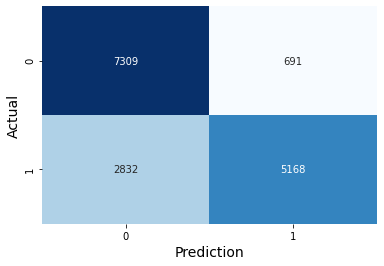

In [48]:
# confusion matrix
import seaborn as sns
conf_mat = confusion_matrix(test_labels, y_hat_class)

ax = sns.heatmap(conf_mat, cmap = 'Blues', annot = True, fmt='.4g', cbar=False)
ax.set_ylabel("Actual", fontsize = 14)
ax.set_xlabel("Prediction",fontsize = 14)